In [1]:
import pandas as pd
import plotnine as pn
import pingouin as pg

print("Pandas: %s"%pd.__version__)
print("Plotnine: %s"%pn.__version__)
print("Pingouin: %s"%pg.__version__)

Pandas: 2.2.3
Plotnine: 0.14.5
Pingouin: 0.5.5


In [2]:
ref = pd.read_csv('annotations.csv')
ref.head()

,path,type,line
0,warrenbuckley/compact-log-format-viewer/run2037-0,human,553
1,warrenbuckley/compact-log-format-viewer/run2037-0,human,501
2,warrenbuckley/compact-log-format-viewer/run2037-0,human,502
3,warrenbuckley/compact-log-format-viewer/run2037-0,human,503
4,warrenbuckley/compact-log-format-viewer/run2037-0,human,504


In [3]:
res = pd.read_csv('result.csv')
res.head()

,path,type,line
0,oramasearch/orama/run626-0,seed,483
1,oramasearch/orama/run626-0,seed,482
2,oramasearch/orama/run626-0,seed,484
3,oramasearch/orama/run626-0,seed,485
4,oramasearch/orama/run626-0,seed,486


In [4]:
ref.groupby("path")["line"].apply(set)
ref.head()
#res.groupby(["path", "type"])["line"].apply(set).unstack(fill_value=set())
res.head()

,path,type,line
0,oramasearch/orama/run626-0,seed,483
1,oramasearch/orama/run626-0,seed,482
2,oramasearch/orama/run626-0,seed,484
3,oramasearch/orama/run626-0,seed,485
4,oramasearch/orama/run626-0,seed,486


In [5]:
def calculate_precision_recall(human_data, algorithm_data):
    # Group data by path for easier processing
    human_lines = human_data.groupby("path")["line"].apply(set)
    algorithm_lines = algorithm_data.groupby(["path", "type"])["line"].apply(set).unstack(fill_value=set())
    
    # Initialize dictionaries to hold precision and recall values
    precision_scores = []
    recall_scores = []
    
    # Loop through each path in the human data
    for path, human_lines_set in human_lines.items():
        for algorithm_type in algorithm_lines.columns:
            # Get the lines identified by the current algorithm for the current path
            algorithm_lines_set = algorithm_lines.loc[path, algorithm_type] if path in algorithm_lines.index else set()
            
            # Calculate true positives, precision, and recall
            true_positives = human_lines_set & algorithm_lines_set
            precision = len(true_positives) / len(algorithm_lines_set) if len(algorithm_lines_set) > 0 else 0
            recall = len(true_positives) / len(human_lines_set) if len(human_lines_set) > 0 else 0
            
            # Store results
            precision_scores.append([path, algorithm_type, precision])
            recall_scores.append([path, algorithm_type, recall])
    
    return precision_scores, recall_scores

In [6]:
(precs, recs) = calculate_precision_recall(ref, res)
precs_df = pd.DataFrame(precs, columns=["path", "algorithm", "precision"])
display(precs_df.head())
recs_df = pd.DataFrame(recs, columns=["path", "algorithm", "recall"])
display(recs_df.head())

,path,algorithm,precision
0,MilanCommunity/Milan/run23-0,lcs,0.007874
1,MilanCommunity/Milan/run23-0,seed,0.009747
2,aiogram/aiogram/run886-0,lcs,0.126761
3,aiogram/aiogram/run886-0,seed,0.321429
4,aiven/pghoard/run840-0,lcs,0.024648


,path,algorithm,recall
0,MilanCommunity/Milan/run23-0,lcs,1.000000
1,MilanCommunity/Milan/run23-0,seed,1.000000
2,aiogram/aiogram/run886-0,lcs,0.818182
3,aiogram/aiogram/run886-0,seed,0.818182
4,aiven/pghoard/run840-0,lcs,1.000000


In [7]:
recs_df[recs_df["recall"] == 0]

,path,algorithm,recall
108,memfault/interrupt/run6-0,lcs,0.0
109,memfault/interrupt/run6-0,seed,0.0


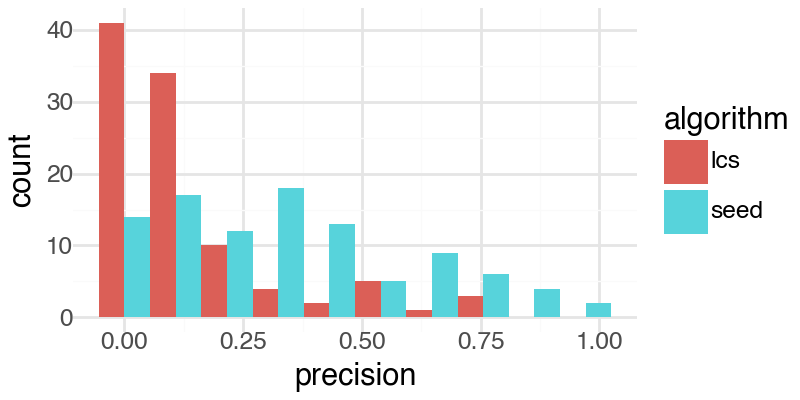

In [8]:
pn.ggplot(precs_df, pn.aes(x="precision", fill="algorithm")) + pn.geom_histogram(position='dodge', bins=10) + pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)) + pn.theme_minimal() + pn.theme(figure_size=(4, 2))

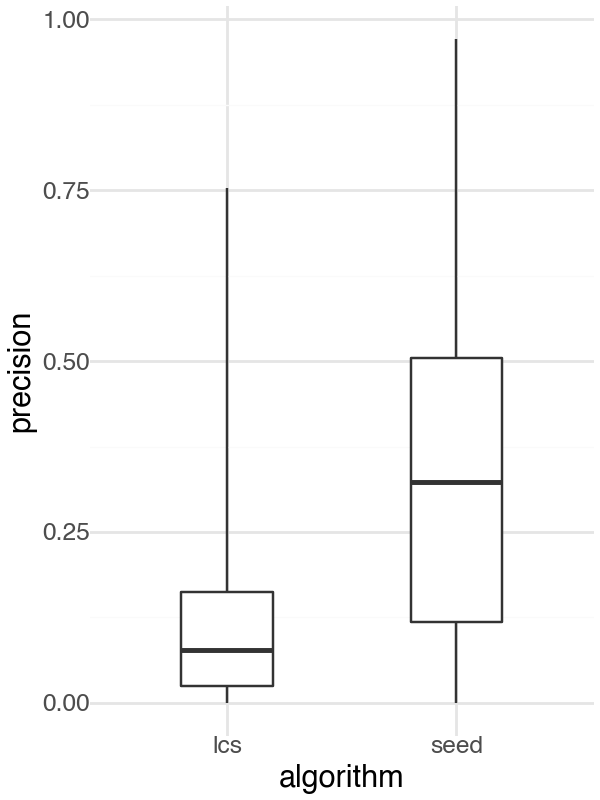

In [95]:
pn.ggplot(precs_df, pn.aes(x="algorithm", y="precision")) + pn.geom_boxplot(coef=1000, width=0.4) + pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)) + pn.theme_minimal() + pn.theme(figure_size=(3, 4))

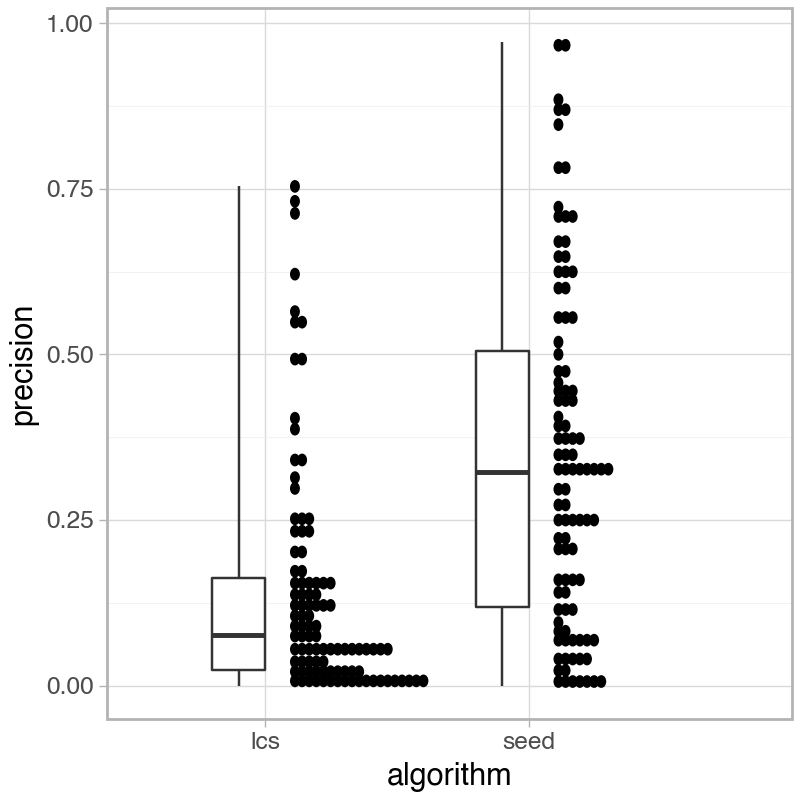

In [112]:
pn.ggplot(precs_df, pn.aes(x="algorithm", y="precision")) + pn.geom_dotplot(binaxis="y", binwidth=0.015, stackdir="up",position=pn.position_nudge(x=0.1)) + pn.geom_boxplot(coef=1000, width=0.2, position=pn.position_nudge(x=-0.1)) + pn.theme_light() + pn.theme(figure_size=(4, 4))

In [118]:
precs_df

,path,algorithm,precision
0,MilanCommunity/Milan/run23-0,lcs,0.007874
1,MilanCommunity/Milan/run23-0,seed,0.009747
2,aiogram/aiogram/run886-0,lcs,0.126761
3,aiogram/aiogram/run886-0,seed,0.321429
4,aiven/pghoard/run840-0,lcs,0.024648
...,...,...,...
195,warrenbuckley/compact-log-format-viewer/run2037-0,seed,0.884298
196,whiskeysockets/baileys/run61-0,lcs,0.007547
197,whiskeysockets/baileys/run61-0,seed,0.029630
198,zeabur/zbpack/run552-0,lcs,0.013129


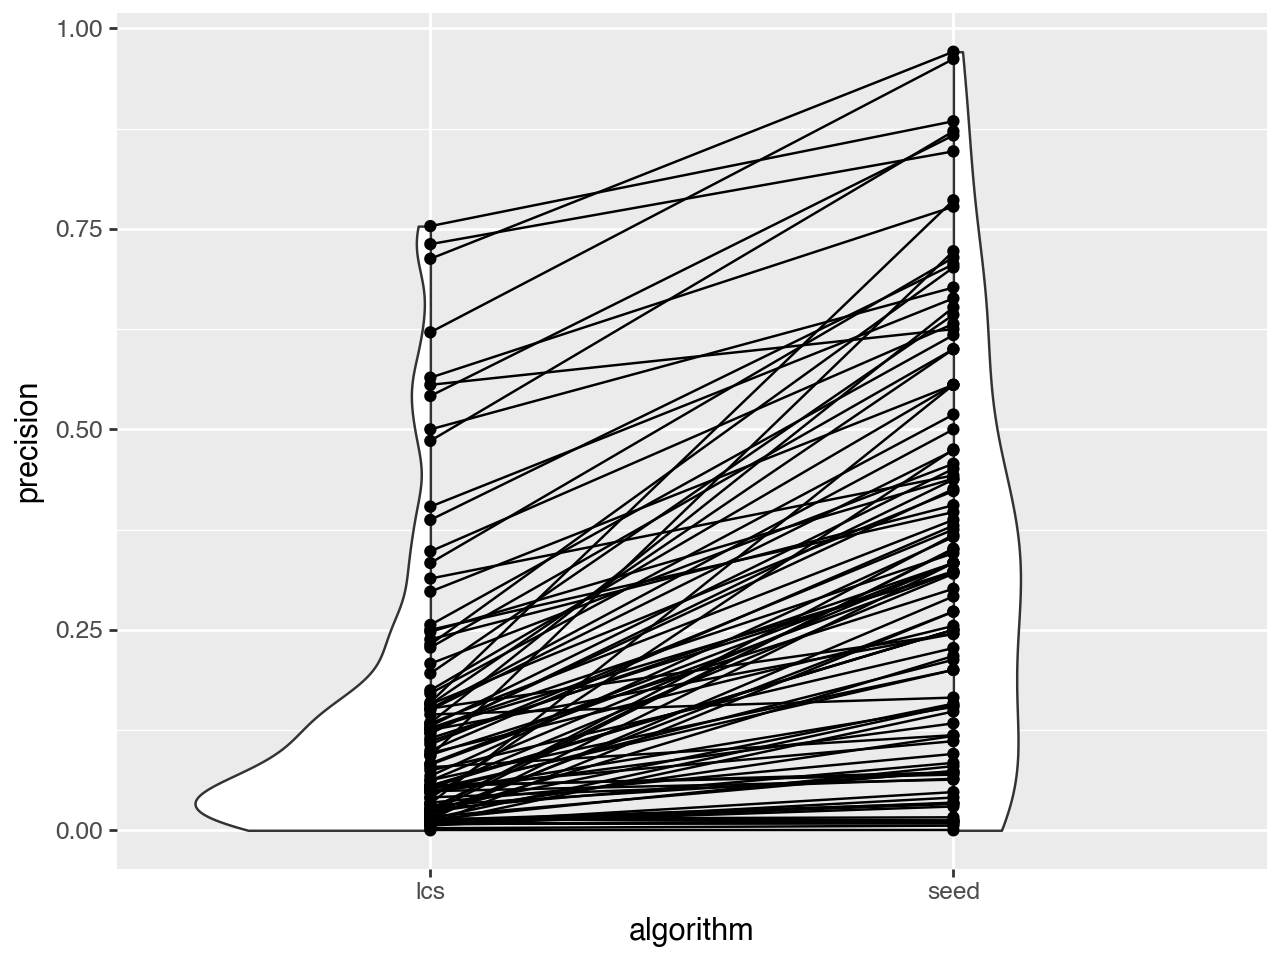

In [119]:
pn.ggplot(precs_df, pn.aes("algorithm", "precision")) + pn.geom_violin(style="left-right") + pn.geom_point() + pn.geom_line(pn.aes(group="path"))


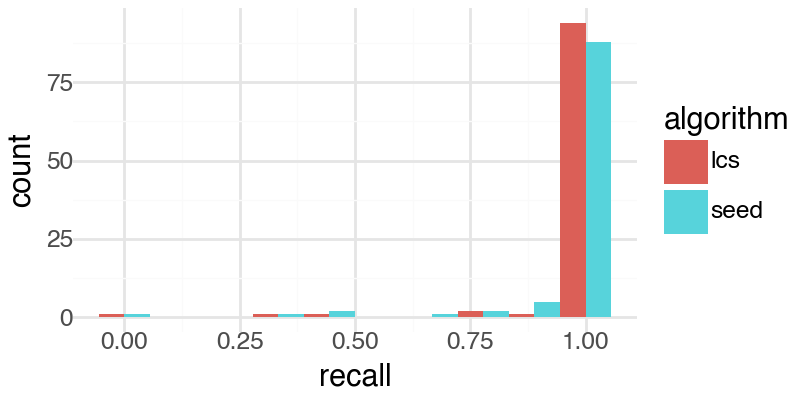

In [67]:
pn.ggplot(recs_df, pn.aes(x="recall", fill="algorithm")) + pn.geom_histogram(position='dodge', bins=10) + pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)) + pn.theme_minimal() + pn.theme(figure_size=(4, 2))

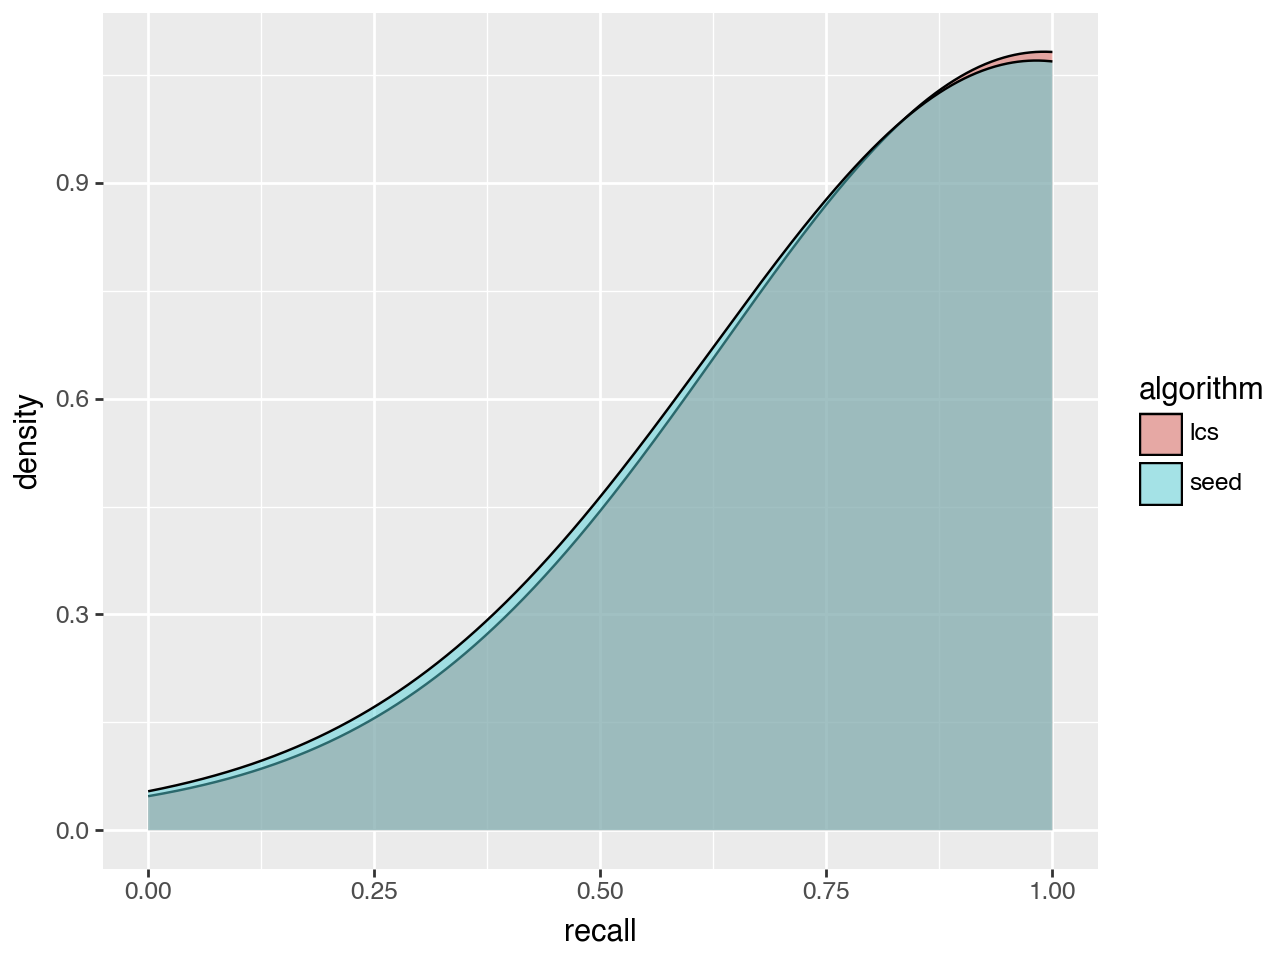

In [110]:
pn.ggplot(recs_df, pn.aes(x="recall", fill="algorithm")) + pn.geom_density(alpha=0.5)

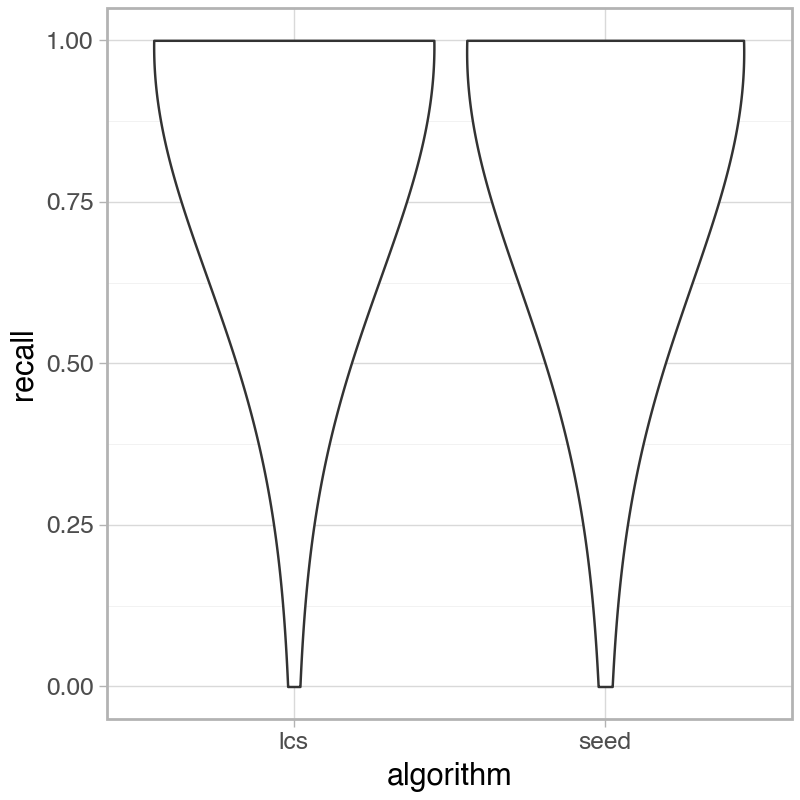

In [113]:
pn.ggplot(recs_df, pn.aes(x="algorithm", y="recall")) + pn.geom_violin() + pn.theme_light() + pn.theme(figure_size=(4, 4))